This notebook extracts MACS peaks that were produced by the snakemake workflow and compares the raw data (no PCR duplicates removed) with data processed to remove PCR duplicates.




In [22]:
species = "Nmel"

min_biorep_support = 2 # minimum number of bioreps to support a peak

qval_threshold = 0 # 1.3 corresponds to pvalue of 0.05, 1 corresponds to pvalue of 0.1
macs_folddiff_threshold = 0 # default 2

# Number of sequences to subsample from each peak set; using the same number to compare across species
number_of_seqs_to_subsample = 1000
number_of_subsamples = 20
# size of interval around peak summit to sample sequences from
interval_size = 200

base_dir = "/Genomics/kocherlab/bjarnold/STARRseq/data"
input_data_dir = f"{base_dir}/peak_calling_snakemake_output/{species}"
output_data_dir = f"{base_dir}/meme_suite/fastas/{species}"
output_plot_dir = f"{base_dir}/plots_raw_vs_dedup/{species}"


bioreps = ['F1', 'F2', 'F3']
chr1_test = False
min_interval_size = 100 # minimum peak interval size to be considered
frac_overlap = 0.5 # fraction of peak overlap to be considered overlapping

import os
os.system(f"mkdir -p {output_data_dir}")
os.system(f"mkdir -p {output_plot_dir}")



0

In [23]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import pyranges as pr
import itertools
from collections import defaultdict
from pyfaidx import Fasta
from Bio.Seq import Seq
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pybedtools as pbt

import sys
sys.path.append("/Genomics/kocherlab/bjarnold/STARRseq/code/notebooks")
import functions as fn

In [24]:
# get MACS peak files
macs_raw_files = fn.get_files(f'{input_data_dir}/MACS2', "*_peaks.narrowPeak")
macs_dedup_files = fn.get_files(f'{input_data_dir}/MACS2_dedup', "*_peaks.narrowPeak")
# print(macs_raw_files)
# print(macs_dedup_files)

# load MACS results
macs_raw_dfs = fn.load_peak_caller_results(macs_raw_files, chr1_test) # list of macs dataframes
macs_dedup_dfs = fn.load_peak_caller_results(macs_dedup_files, chr1_test) # list of macs dataframes

# filter MACS results by qval and fold diff
macs_raw_dfs = fn.filter_by_sig_effect_size(macs_raw_dfs, qval_threshold, macs_folddiff_threshold)
macs_dedup_dfs = fn.filter_by_sig_effect_size(macs_dedup_dfs, qval_threshold, macs_folddiff_threshold)

# convert to pyrange objects
macs_raw_prs = [pr.PyRanges(m) for m in macs_raw_dfs]
macs_dedup_prs = [pr.PyRanges(m) for m in macs_dedup_dfs]

print([len(df) for df in macs_raw_dfs])
print([len(df) for df in macs_dedup_dfs])


# load repeatmodeler intervals
repeat_file = f'{base_dir}/repeat_modeler_intervals/{species}_repeat_elements.bed'
# can't read with pandas because variable number of columns; some rows marked with an asterisk if the repeat overlaps with another higher-scoring repeat
# load by reading in all lines instead, then importing into table
# then use pyranges to merge overlapping intervals
# repeat_pr = fn.load_repeat_modeler_intervals(repeat_file)




before filtering: 103313
after filtering: 103313
before filtering: 101930
after filtering: 101930
before filtering: 104845
after filtering: 104845
before filtering: 9645
after filtering: 9645
before filtering: 13153
after filtering: 13153
before filtering: 12217
after filtering: 12217
[103313, 101930, 104845]
[9645, 13153, 12217]


In [25]:
# open reference genome ref_genome, count the length of each chromosome, and store in a dictionary
# ref_genome = f'{base_dir}/alternate_references/renamed/{species}.fasta'
ref_genome_locs = '/Genomics/kocherlab/bjarnold/STARRseq/data/reference_genome_locations.txt'
ref_genome = None
with open(ref_genome_locs, 'r') as f:
    for line in f:
        line = line.strip().split()
        if line[0] == species[0:4]:
            ref_genome = line[1]
if ref_genome is None:
    raise Exception(f"Could not find reference genome for {species}")
fasta_sequences = Fasta(ref_genome)

# get scaffold lengths, which we later use to make sure kmers don't overhang edges of scaffolds
scaff_lengths = defaultdict(int)
# Iterate over the sequences and print their names and lengths
for sequence_name in fasta_sequences.keys():
    scaff_lengths[sequence_name] = len(fasta_sequences[sequence_name])


## Plot peak interval lengths

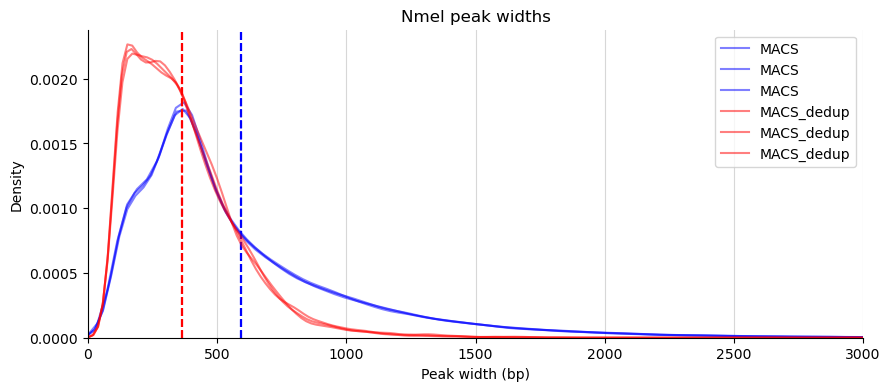

In [26]:
# note for Genrich, peaks thresholded by q value selects for wider peaks with larger q values
fig, axs = plt.subplots(1, 1, figsize=(10, 4), sharex=True, sharey=True)
for df in macs_raw_dfs:
    sns.kdeplot(df['End']-df['Start'], color="blue", alpha=0.5, label="MACS")
    axs.axvline(x=np.mean(df['End']-df['Start']), color="blue", linestyle='--')
for df in macs_dedup_dfs:
    sns.kdeplot(df['End']-df['Start'], color="red", alpha=0.5, label="MACS_dedup")
    axs.axvline(x=np.mean(df['End']-df['Start']), color="red", linestyle='--')
axs.set_xlim(0,3000)
axs.set_xlabel("Peak width (bp)")
axs.set_ylabel("Density")
axs.set_title(f"{species} peak widths")
axs.grid(axis='x', alpha=0.5)  
# add legend
handles, labels = axs.get_legend_handles_labels()
axs.legend(handles, labels)
sns.despine()

plt.savefig(f"{output_plot_dir}/peak_widths.png", dpi=300, bbox_inches='tight')


## Plot fold differences from raw and deduplicated MACS peaks

original df length: 9645
df length after join: 9649
[[1.        0.6160841]
 [0.6160841 1.       ]]
original df length: 13153
df length after join: 13157
[[1.         0.59618008]
 [0.59618008 1.        ]]
original df length: 12217
df length after join: 12220
[[1.         0.61343318]
 [0.61343318 1.        ]]


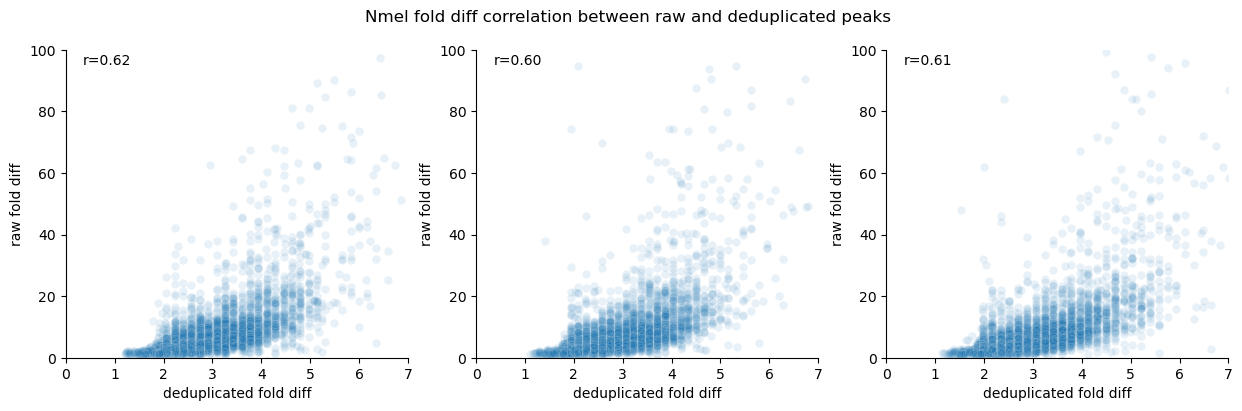

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

for i,(dedup,raw) in enumerate(zip(macs_dedup_prs, macs_raw_prs)):
    tmp = dedup.join(raw, suffix="_raw", how="left")
    print("original df length:", len(dedup))
    print("df length after join:", len(tmp))
    sns.scatterplot(data=tmp.df, x="signalValue", y="signalValue_raw", alpha=0.1, ax=axs[i])   
    axs[i].set_xlim(0,7)
    axs[i].set_ylim(0,100)

    axs[i].set_xlabel("deduplicated fold diff")
    axs[i].set_ylabel("raw fold diff")

    # add correlation coefficient to plot
    axs[i].text(0.05, 0.95, f"r={np.corrcoef(tmp.df['signalValue'], tmp.df['signalValue_raw'])[0,1]:.2f}", transform=axs[i].transAxes)
    print(np.corrcoef(tmp.df["signalValue"], tmp.df["signalValue_raw"]))
sns.despine()
# set title
fig.suptitle(f"{species} fold diff correlation between raw and deduplicated peaks")

plt.savefig(f"{output_plot_dir}/fold_diff_correlation.png", dpi=300, bbox_inches='tight')

# COMPARE PEAKS by overlapping intervals, across biological replicates

In [28]:

# look at concordance of peak calling between methods, witihin bioreps
macs_raw_overlaps, macs_dedup_overlaps = fn.get_peak_overlaps_between_method_within_reps(macs_raw_dfs, macs_dedup_dfs, frac_overlap)

print(macs_raw_overlaps)
print(macs_dedup_overlaps)
for i,m in enumerate(macs_raw_overlaps):
    print(f"MACS2 raw: {m[0]} peaks, {m[1]*100:.2f}% overlap with deduplicated peaks")
for i,m in enumerate(macs_dedup_overlaps):
    print(f"MACS2 deduplicated: {m[0]} peaks, {m[1]*100:.2f}% overlap with raw peaks")

# fraction of overlap can seem odd if one caller has smaller peaks that are contained within a larger peak from the other caller

[(103313, 0.024237027286014345), (101930, 0.03743745707838713), (104845, 0.03430778768658496)]
[(9645, 0.9838258164852255), (13153, 0.9825895233026686), (12217, 0.9797004174510927)]
MACS2 raw: 103313 peaks, 2.42% overlap with deduplicated peaks
MACS2 raw: 101930 peaks, 3.74% overlap with deduplicated peaks
MACS2 raw: 104845 peaks, 3.43% overlap with deduplicated peaks
MACS2 deduplicated: 9645 peaks, 98.38% overlap with raw peaks
MACS2 deduplicated: 13153 peaks, 98.26% overlap with raw peaks
MACS2 deduplicated: 12217 peaks, 97.97% overlap with raw peaks


In [29]:
# look at overlaps within methods between bioreps
macs_raw_overlaps = fn.get_peak_overlaps_within_method_between_reps(macs_raw_dfs, bioreps, frac_overlap)
macs_dedup_overlaps = fn.get_peak_overlaps_within_method_between_reps(macs_dedup_dfs, bioreps, frac_overlap)

print(macs_raw_overlaps)
print(macs_dedup_overlaps)

[(103313, 101930, 35510), (103313, 104845, 35235), (101930, 104845, 35311)]
[(9645, 13153, 4976), (9645, 12217, 4722), (13153, 12217, 5188)]


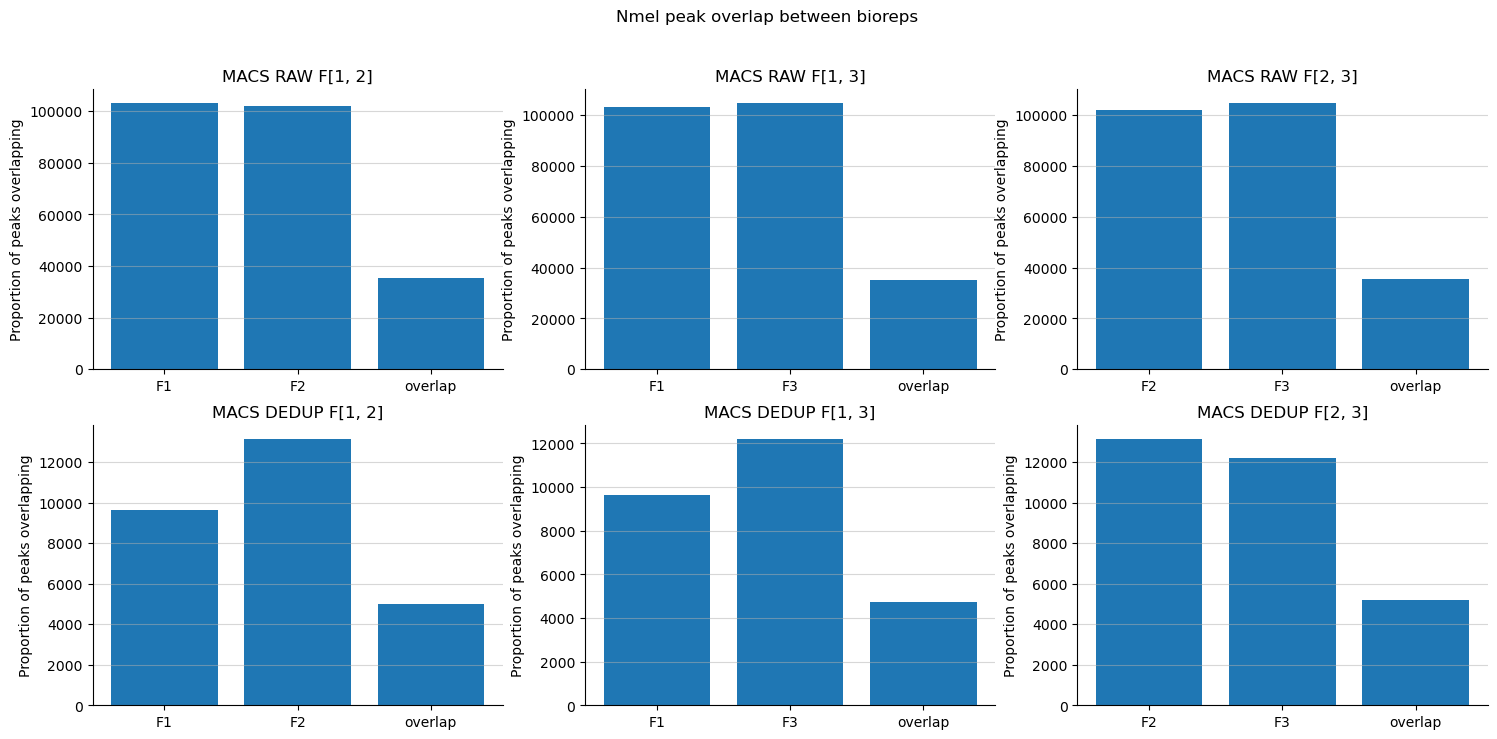

In [30]:
biorep_comb = list(itertools.combinations(range(len(bioreps)), 2))
fig, axs = plt.subplots(2, 3, figsize=(18, 8), sharex=False, sharey=False)
for i,comp in enumerate(macs_raw_overlaps):
    rep = biorep_comb[i]
    rep = [int(r)+1 for r in rep]
    l = [f"F{rep[0]}", f"F{rep[1]}", "overlap"]
    axs[0][i].bar(range(len(comp)), comp)
    axs[0][i].set_title(f"MACS RAW F{rep}")
    axs[0][i].set_ylabel("Proportion of peaks overlapping")
    axs[0][i].set_xticks(range(len(l)))
    axs[0][i].set_xticklabels(l, rotation=0)
    axs[0][i].grid(axis='y', alpha=0.5)    
for i,comp in enumerate(macs_dedup_overlaps):
    rep = biorep_comb[i]
    rep = [int(r)+1 for r in rep]
    l = [f"F{rep[0]}", f"F{rep[1]}", "overlap"]
    axs[1][i].bar(range(len(comp)), comp)
    axs[1][i].set_title(f"MACS DEDUP F{rep}")
    axs[1][i].set_ylabel("Proportion of peaks overlapping")
    axs[1][i].set_xticks(range(len(l)))
    axs[1][i].set_xticklabels(l, rotation=0)
    axs[1][i].grid(axis='y', alpha=0.5)    
sns.despine()
# add title
fig.suptitle(f"{species} peak overlap between bioreps")

plt.savefig(f"{output_plot_dir}/peak_overlap_within_method_between_reps.png", dpi=300, bbox_inches='tight')

## Find peaks present in all 3 bioreps

In [31]:
# convert each df to a pyranges object, count overlaps among biological replicates

macs_raw_overlaps_per_rep = fn.overlaps_per_replicate(macs_raw_dfs)
macs_dedup_overlaps_per_rep = fn.overlaps_per_replicate(macs_dedup_dfs)
# it looks like count_overlaps is counting overlaps b/t all instervals
# if all three replicates have an overlapping interval, pattern could look like this:
#       Chromosome	Start	End	    p1	p2	p3
# 7	    NMEL_chr_1	9079	9297	0	0	0
# 8	    NMEL_chr_1	9297	9309	1	0	0
# 9	    NMEL_chr_1	9309	9649	1	1	0
# 10	NMEL_chr_1	9649	10150	1	1	1
# 11	NMEL_chr_1	10150	10843	0	1	1
# 12	NMEL_chr_1	10843	10914	0	0	1
# 13	NMEL_chr_1	10914	16276	0	0	0
# where index 10 is interval in which all 3 peaks are overlapping, but since start/end points of the peaksare different,
# we can see that replicate 1 has the minimum starting point, and replicate 3 has the maximum ending point

macs_raw_overlaps_per_rep.head()

,Chromosome,Start,End,p1,p2,p3,combined
0,NMEL_chr_1,434,464,0,1,0,010
1,NMEL_chr_1,464,963,1,1,0,110
2,NMEL_chr_1,963,993,0,1,0,010
3,NMEL_chr_1,993,1473,0,0,0,000
4,NMEL_chr_1,1473,1677,1,0,0,100


In [32]:
print(macs_raw_overlaps_per_rep.combined.unique())
print(macs_dedup_overlaps_per_rep.combined.unique())

['010' '110' '000' '100' '011' '001' '111' '101']
['100' '110' '111' '101' '001' '000' '010' '011']


In [33]:
def get_triplet_peaks(overlaps_df, min_interval_size, method):
    trips_df = overlaps_df[(overlaps_df['End']-overlaps_df['Start'] > min_interval_size) & 
                            (overlaps_df['combined'] == '111')]                          
    trips_df['method'] = method
    return trips_df
    
macs_raw_trips_df = get_triplet_peaks(macs_raw_overlaps_per_rep, min_interval_size, 'macs_raw')
macs_dedup_trips_df = get_triplet_peaks(macs_dedup_overlaps_per_rep, min_interval_size, 'macs_dedup')

macs_raw_trips_df.reset_index(inplace=True, drop=True)
macs_dedup_trips_df.reset_index(inplace=True, drop=True)

with open(f"./MACS2_summaries/{species}_MACS2_peaks.txt",'w') as o:
    o.write(" ".join(["species", "raw", "dedup", "\n"]))
    o.write(" ".join([species, str(len(macs_raw_trips_df)), str(len(macs_dedup_trips_df)), "\n"]))

def get_signal_val_and_peak_coord_for_trips_df(trips_df, prs):
    tmp_pr = pr.PyRanges(trips_df)
    for i in range(len(prs)):
        tmp_join = tmp_pr.join(prs[i], suffix="_raw", how="left")
        tmp_join = tmp_join.df.reset_index(drop=True, inplace=False)
        # concatenate signalValue as column to macs_raw_trips_df
        assert len(tmp_join['signalValue']) == len(trips_df)
        trips_df[f'signalValue_{i}'] = tmp_join['signalValue']
        trips_df[f'peak_coord_{i}'] = tmp_join['peak_coord']
    return trips_df

macs_raw_trips_df = get_signal_val_and_peak_coord_for_trips_df(macs_raw_trips_df, macs_raw_prs)
macs_dedup_trips_df = get_signal_val_and_peak_coord_for_trips_df(macs_dedup_trips_df, macs_dedup_prs)

/tmp/ipykernel_2119420/3981973104.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trips_df['method'] = method
/tmp/ipykernel_2119420/3981973104.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trips_df['method'] = method
/tmp/ipykernel_2119420/3981973104.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

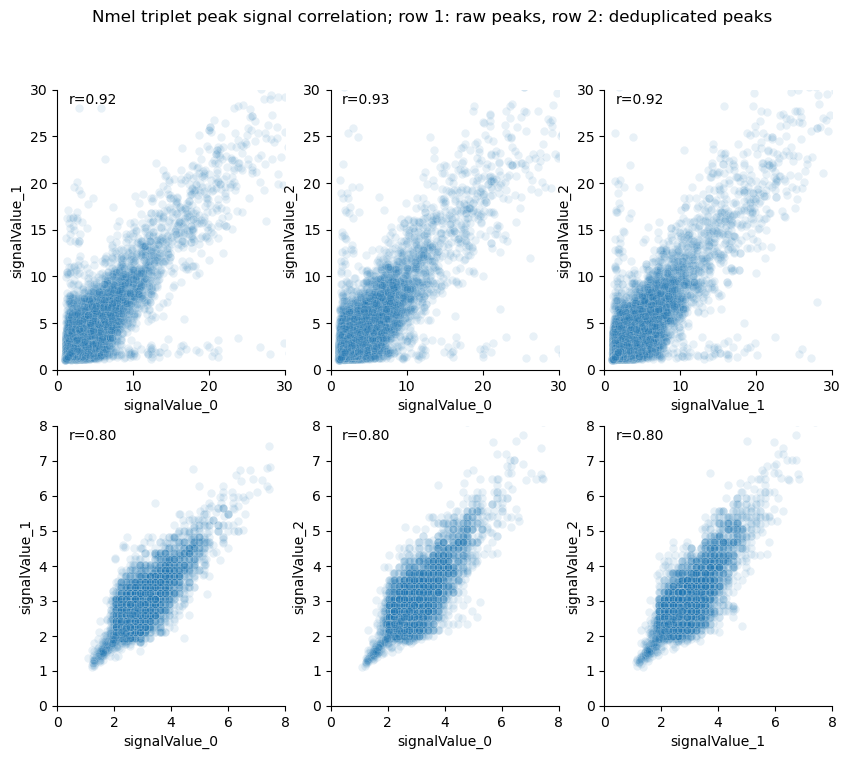

In [34]:
# make pairwise comparisons of signal values columns
fig, axs = plt.subplots(2, 3, figsize=(10, 8), sharex=False, sharey=False)
#get all combinations of integers between 0 and 2
for i, comb in enumerate(list(itertools.combinations(range(3), 2))):
    sns.scatterplot(data=macs_raw_trips_df, x=f"signalValue_{comb[0]}", y=f"signalValue_{comb[1]}", alpha=0.1, ax=axs[0][i])
    axs[0][i].set_xlim(0,30)
    axs[0][i].set_ylim(0,30)
    # print pearson correlation coefficient
    axs[0][i].text(0.05, 0.95, f"r={np.corrcoef(macs_raw_trips_df[f'signalValue_{comb[0]}'], macs_raw_trips_df[f'signalValue_{comb[1]}'])[0,1]:.2f}", transform=axs[0][i].transAxes)


    sns.scatterplot(data=macs_dedup_trips_df, x=f"signalValue_{comb[0]}", y=f"signalValue_{comb[1]}", alpha=0.1, ax=axs[1][i])
    axs[1][i].set_xlim(0,8)
    axs[1][i].set_ylim(0,8)
    # print pearson correlation coefficient
    axs[1][i].text(0.05, 0.95, f"r={np.corrcoef(macs_dedup_trips_df[f'signalValue_{comb[0]}'], macs_dedup_trips_df[f'signalValue_{comb[1]}'])[0,1]:.2f}", transform=axs[1][i].transAxes)
sns.despine()

# add title
fig.suptitle(f"{species} triplet peak signal correlation; row 1: raw peaks, row 2: deduplicated peaks")
plt.savefig(f"{output_plot_dir}/triplet_peak_signal_correlation_across_reps.png", dpi=300, bbox_inches='tight')

### compute mean signal value, mean peak coordinate

In [35]:
# compute the mean signal value across replicates
macs_raw_trips_df['mean_signalValue'] = macs_raw_trips_df[[f'signalValue_{i}' for i in range(3)]].mean(axis=1)
macs_dedup_trips_df['mean_signalValue'] = macs_dedup_trips_df[[f'signalValue_{i}' for i in range(3)]].mean(axis=1)

# get mean peak_coord and convert to integer
macs_raw_trips_df['mean_peak_coord'] = macs_raw_trips_df[[f'peak_coord_{i}' for i in range(3)]].mean(axis=1).astype(int)
macs_dedup_trips_df['mean_peak_coord'] = macs_dedup_trips_df[[f'peak_coord_{i}' for i in range(3)]].mean(axis=1).astype(int)



/tmp/ipykernel_2119420/170786559.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  macs_raw_trips_df['mean_signalValue'] = macs_raw_trips_df[[f'signalValue_{i}' for i in range(3)]].mean(axis=1)
/tmp/ipykernel_2119420/170786559.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  macs_dedup_trips_df['mean_signalValue'] = macs_dedup_trips_df[[f'signalValue_{i}' for i in range(3)]].mean(axis=1)
/tmp/ipykernel_2119420/170786559.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

### get interval coordinates around mean peak coordinate

In [36]:
# extend mean peak coordinate to match interval size
macs_raw_trips_df['peak_Start'] = macs_raw_trips_df['mean_peak_coord'] - int(interval_size/2)
macs_raw_trips_df['peak_End'] = macs_raw_trips_df['mean_peak_coord'] + int(interval_size/2)

macs_dedup_trips_df['peak_Start'] = macs_dedup_trips_df['mean_peak_coord'] - int(interval_size/2)
macs_dedup_trips_df['peak_End'] = macs_dedup_trips_df['mean_peak_coord'] + int(interval_size/2)

/tmp/ipykernel_2119420/2277522570.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  macs_raw_trips_df['peak_Start'] = macs_raw_trips_df['mean_peak_coord'] - int(interval_size/2)
/tmp/ipykernel_2119420/2277522570.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  macs_raw_trips_df['peak_End'] = macs_raw_trips_df['mean_peak_coord'] + int(interval_size/2)
/tmp/ipykernel_2119420/2277522570.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [37]:
macs_raw_trips_df

,Chromosome,Start,End,p1,p2,p3,combined,method,signalValue_0,peak_coord_0,signalValue_1,peak_coord_1,signalValue_2,peak_coord_2,mean_signalValue,mean_peak_coord,peak_Start,peak_End
0,NMEL_chr_1,9111,10147,1,1,1,111,macs_raw,6.93128,9798,5.49904,9857,3.62292,9938,5.351080,9864,9764,9964
1,NMEL_chr_1,10860,11081,1,1,1,111,macs_raw,1.15928,10949,5.49904,9857,3.62292,9938,3.427080,10248,10148,10348
2,NMEL_chr_1,17245,17624,1,1,1,111,macs_raw,1.73014,17810,2.92806,17682,1.53939,17278,2.065863,17590,17490,17690
3,NMEL_chr_1,23166,23429,1,1,1,111,macs_raw,1.80943,23056,2.08892,23221,1.60770,23653,1.835350,23310,23210,23410
4,NMEL_chr_1,36798,37049,1,1,1,111,macs_raw,2.12657,37065,3.62437,36696,1.18075,36979,2.310563,36913,36813,37013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30926,NMEL_unplaced_2944,66,831,1,1,1,111,macs_raw,1.12800,91,1.14982,93,1.10823,91,1.128683,91,-9,191
30927,NMEL_unplaced_2947,72,961,1,1,1,111,macs_raw,1.86240,583,1.85615,582,1.84735,582,1.855300,582,482,682
30928,NMEL_unplaced_2953,212,754,1,1,1,111,macs_raw,1.38644,502,1.38979,502,1.34682,497,1.374350,500,400,600
30929,NMEL_unplaced_2954,228,783,1,1,1,111,macs_raw,2.07900,245,2.46385,682,2.76902,648,2.437290,525,425,625


In [38]:
macs_dedup_trips_df

,Chromosome,Start,End,p1,p2,p3,combined,method,signalValue_0,peak_coord_0,signalValue_1,peak_coord_1,signalValue_2,peak_coord_2,mean_signalValue,mean_peak_coord,peak_Start,peak_End
0,NMEL_chr_1,46352,46557,1,1,1,111,macs_dedup,2.22831,46492,2.73626,46502,2.69679,46497,2.553787,46497,46397,46597
1,NMEL_chr_1,177141,177372,1,1,1,111,macs_dedup,2.91394,177187,2.73626,177444,2.51701,177149,2.722403,177260,177160,177360
2,NMEL_chr_1,212172,212636,1,1,1,111,macs_dedup,4.79943,212406,3.70200,212225,6.65209,212464,5.051173,212365,212265,212465
3,NMEL_chr_1,251454,251555,1,1,1,111,macs_dedup,2.57112,251495,2.09243,251476,2.33722,251557,2.333590,251509,251409,251609
4,NMEL_chr_1,291407,291718,1,1,1,111,macs_dedup,2.05690,291679,2.33782,291489,3.22237,291656,2.539030,291608,291508,291708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4242,NMEL_unplaced_2933,327,716,1,1,1,111,macs_dedup,1.38265,529,1.57379,676,1.52467,549,1.493703,584,484,684
4243,NMEL_unplaced_2944,48,856,1,1,1,111,macs_dedup,2.65129,293,2.57515,286,2.65476,284,2.627067,287,187,387
4244,NMEL_unplaced_2947,57,975,1,1,1,111,macs_dedup,3.08516,568,2.94701,568,3.10252,568,3.044897,568,468,668
4245,NMEL_unplaced_2953,178,948,1,1,1,111,macs_dedup,2.45818,494,2.41887,501,2.45857,502,2.445207,499,399,599


In [39]:
# get rid of intervals that go beyond boundaries of scaffolds
def get_indices_of_overhangs(df, scaff_lengths):
    # get indices of intervals that overhang scaffolds
    overhang_indices = []
    for i,r in df.iterrows():
        if (r['peak_Start'] < 0) or (r['peak_End'] > scaff_lengths[r['Chromosome']]):
            overhang_indices.append(i)
    return overhang_indices

macs_raw_overhang_indices = get_indices_of_overhangs(macs_raw_trips_df, scaff_lengths) 
macs_dedup_overhang_indices = get_indices_of_overhangs(macs_dedup_trips_df, scaff_lengths)

print(len(macs_raw_overhang_indices))
print(len(macs_dedup_overhang_indices))

# get all indices of macs_raw_trips_df except for those in macs_raw_overhang_indices
macs_raw_trips_df = macs_raw_trips_df[~macs_raw_trips_df.index.isin(macs_raw_overhang_indices)].reset_index(drop=True)
macs_dedup_trips_df = macs_dedup_trips_df[~macs_dedup_trips_df.index.isin(macs_dedup_overhang_indices)].reset_index(drop=True)
 

3
1


In [40]:
macs_raw_trips_df

,Chromosome,Start,End,p1,p2,p3,combined,method,signalValue_0,peak_coord_0,signalValue_1,peak_coord_1,signalValue_2,peak_coord_2,mean_signalValue,mean_peak_coord,peak_Start,peak_End
0,NMEL_chr_1,9111,10147,1,1,1,111,macs_raw,6.93128,9798,5.49904,9857,3.62292,9938,5.351080,9864,9764,9964
1,NMEL_chr_1,10860,11081,1,1,1,111,macs_raw,1.15928,10949,5.49904,9857,3.62292,9938,3.427080,10248,10148,10348
2,NMEL_chr_1,17245,17624,1,1,1,111,macs_raw,1.73014,17810,2.92806,17682,1.53939,17278,2.065863,17590,17490,17690
3,NMEL_chr_1,23166,23429,1,1,1,111,macs_raw,1.80943,23056,2.08892,23221,1.60770,23653,1.835350,23310,23210,23410
4,NMEL_chr_1,36798,37049,1,1,1,111,macs_raw,2.12657,37065,3.62437,36696,1.18075,36979,2.310563,36913,36813,37013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30923,NMEL_unplaced_2943,239,524,1,1,1,111,macs_raw,1.93628,461,1.73184,409,1.76140,491,1.809840,453,353,553
30924,NMEL_unplaced_2947,72,961,1,1,1,111,macs_raw,1.86240,583,1.85615,582,1.84735,582,1.855300,582,482,682
30925,NMEL_unplaced_2953,212,754,1,1,1,111,macs_raw,1.38644,502,1.38979,502,1.34682,497,1.374350,500,400,600
30926,NMEL_unplaced_2954,228,783,1,1,1,111,macs_raw,2.07900,245,2.46385,682,2.76902,648,2.437290,525,425,625


In [41]:
macs_raw_trips_df

,Chromosome,Start,End,p1,p2,p3,combined,method,signalValue_0,peak_coord_0,signalValue_1,peak_coord_1,signalValue_2,peak_coord_2,mean_signalValue,mean_peak_coord,peak_Start,peak_End
0,NMEL_chr_1,9111,10147,1,1,1,111,macs_raw,6.93128,9798,5.49904,9857,3.62292,9938,5.351080,9864,9764,9964
1,NMEL_chr_1,10860,11081,1,1,1,111,macs_raw,1.15928,10949,5.49904,9857,3.62292,9938,3.427080,10248,10148,10348
2,NMEL_chr_1,17245,17624,1,1,1,111,macs_raw,1.73014,17810,2.92806,17682,1.53939,17278,2.065863,17590,17490,17690
3,NMEL_chr_1,23166,23429,1,1,1,111,macs_raw,1.80943,23056,2.08892,23221,1.60770,23653,1.835350,23310,23210,23410
4,NMEL_chr_1,36798,37049,1,1,1,111,macs_raw,2.12657,37065,3.62437,36696,1.18075,36979,2.310563,36913,36813,37013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30923,NMEL_unplaced_2943,239,524,1,1,1,111,macs_raw,1.93628,461,1.73184,409,1.76140,491,1.809840,453,353,553
30924,NMEL_unplaced_2947,72,961,1,1,1,111,macs_raw,1.86240,583,1.85615,582,1.84735,582,1.855300,582,482,682
30925,NMEL_unplaced_2953,212,754,1,1,1,111,macs_raw,1.38644,502,1.38979,502,1.34682,497,1.374350,500,400,600
30926,NMEL_unplaced_2954,228,783,1,1,1,111,macs_raw,2.07900,245,2.46385,682,2.76902,648,2.437290,525,425,625


## Save intervals as BED file, load into pybedtools object to extract underlying sequences from FASTA file, since this function is bugged in PyRanges

### Since raw data likely has many more peaks compared to deduplicated data, downsample raw data to as many observations in deduplicated data, since you may find more TFBS enrichment from sampling random regions of the genome

In [42]:
# load in reference genome as pybedtools object
ref_genome_pbt = pbt.example_filename(ref_genome)

# save deduplicated data: 1.) save data as BED, 2.) load BED into pybedtools 3.) make FASTA file
# macs_dedup_trips_df[['Chromosome', 'peak_Start', 'peak_End']].to_csv(f'{output_data_dir}/MACS2_triplet_peaks_dedup.bed', sep='\t', header=False, index=False)
# macs_dedup_trips_pbt = pbt.BedTool(f'{output_data_dir}/MACS2_triplet_peaks_dedup.bed')
# macs_dedup_trips_pbt.sequence(fi=ref_genome_pbt, fo=f"{output_data_dir}/MACS2_triplet_peaks_dedup.fa")


# randomly sample rows from macs_raw_trips_df
for i in range(number_of_subsamples):
    macs_raw_trips_subsamp_df = macs_raw_trips_df.sample(n=number_of_seqs_to_subsample).reset_index(drop=True) 
    macs_raw_trips_subsamp_df[['Chromosome', 'peak_Start', 'peak_End']].to_csv(f'{output_data_dir}/MACS2_triplet_peaks_raw_rep{i}.bed', sep='\t', header=False, index=False)
    macs_raw_trips_subsamp_pbt = pbt.BedTool(f'{output_data_dir}/MACS2_triplet_peaks_raw_rep{i}.bed')
    macs_raw_trips_subsamp_pbt.sequence(fi=ref_genome_pbt, fo=f"{output_data_dir}/MACS2_triplet_peaks_raw_rep{i}.fa")

# randomly sample rows from macs_dedup_trips_df
for i in range(number_of_subsamples):
    macs_dedup_trips_subsamp_df = macs_dedup_trips_df.sample(n=number_of_seqs_to_subsample).reset_index(drop=True) 
    macs_dedup_trips_subsamp_df[['Chromosome', 'peak_Start', 'peak_End']].to_csv(f'{output_data_dir}/MACS2_triplet_peaks_dedup_rep{i}.bed', sep='\t', header=False, index=False)
    macs_dedup_trips_subsamp_pbt = pbt.BedTool(f'{output_data_dir}/MACS2_triplet_peaks_dedup_rep{i}.bed')
    macs_dedup_trips_subsamp_pbt.sequence(fi=ref_genome_pbt, fo=f"{output_data_dir}/MACS2_triplet_peaks_dedup_rep{i}.fa")

for i in range(number_of_subsamples):
    x = pbt.BedTool()
    y = x.random(l=interval_size, n=number_of_seqs_to_subsample, g=f"{ref_genome}.fai")
    y.sequence(fi=ref_genome_pbt, fo=f"{output_data_dir}/MACS2_triplet_peaks_random_rep{i}.fa")


# print(open(tmp.seqfn).read())
